In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.linalg as la
import pyvista as pv
import imageio.v3 as iio
np.set_printoptions(formatter={"float": "{:10.2f}".format})

In [3]:
from src.experiment import Experiment
from src.pycv.dmcp import dm_to_world
mesh_path = "/home/julian/uni/ushichka-registration/data/formatted/lidar_roi.ply"
mesh_path = "C:/Users/Julian/Nextcloud/Uni/Semester 8/ushichka-registration/data/formatted/lidar_roi.ply"
pvMesh = pv.read(mesh_path)

In [4]:
day = "/home/julian/data/dmcp_experiments/round_03/2018-08-19"
day = "/data/dmcp_experiments/round_03/2018-08-19"
def path_day_cam(day,cam):
    exp_path = f"{day}--cam{cam}"
    return exp_path

In [5]:
pc0 = path_day_cam(day,0)
pc1 = path_day_cam(day,1)
pc2 = path_day_cam(day,2)

exp0 = Experiment(pc0,mesh_path)
exp1 = Experiment(pc1,mesh_path)
exp2 = Experiment(pc2,mesh_path)
exps = [exp0, exp1, exp2]

In [6]:
exp = exp0
exp.visualize_3D()

[     -0.72       3.35       0.53]


In [7]:
dmIm = exp.load_dmIm()
dmK = exp.load_dmK()
dmP = exp.load_dmP()
cps = exp.load_cps()
imIm = exp.load_imIm()
imK = exp.load_imK()
imP = exp.load_imP()
trans = exp.load_transform()
pts_world = dm_to_world(dmIm, dmK, dmP, cps[:,2:])


In [ ]:
plotter = pv.Plotter(notebook=False)
posM = pv.PolyData(pts_world)
plotter.add_mesh(pvMesh)
plotter.add_mesh(posM, color="blue", point_size=25,render_points_as_spheres=True)
plotter.show()

# demonstrate how to image extrinsics are expected to work using dm

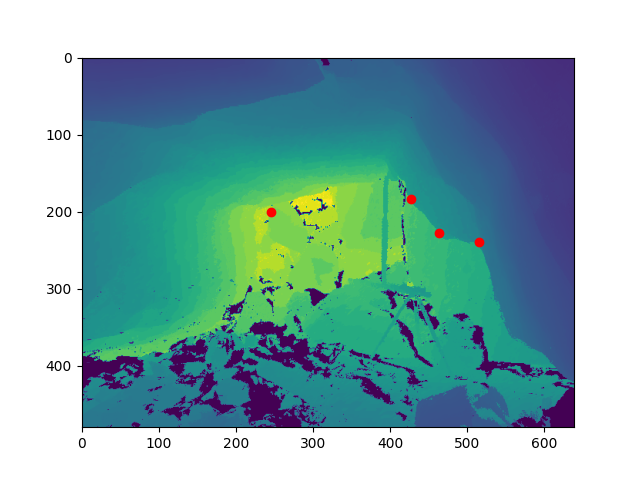

In [9]:
pts_world_hat = np.hstack((pts_world, np.ones((pts_world.shape[0],1))))
reproj_by_P = (dmP @ pts_world_hat.T).T
reproj_by_P = np.array([ reproj_by_P[:,0]/ reproj_by_P[:,-1],reproj_by_P[:,1]/ reproj_by_P[:,-1]]).T

plt.figure()
plt.imshow(dmIm)
plt.scatter(reproj_by_P[:,0],reproj_by_P[:,1], c="r")
plt.show()

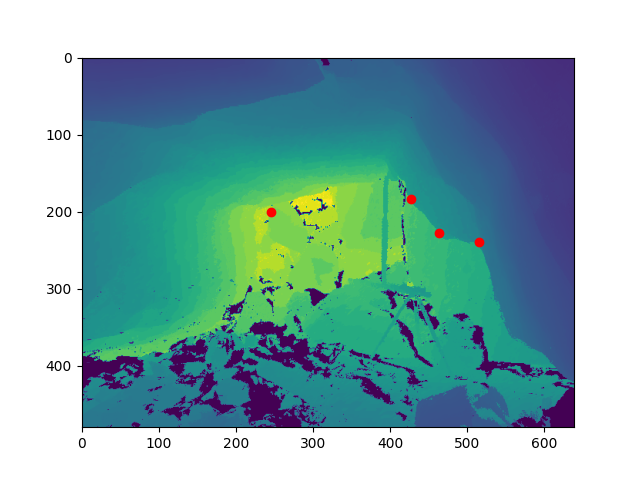

In [10]:
pts_world_hat = np.hstack((pts_world, np.ones((pts_world.shape[0],1))))

extr_dm = la.inv(dmK) @ dmP
pts_in_dmCam = (extr_dm @ pts_world_hat.T).T
pts_in_dmCam

reproj_by_ext = (dmK @ pts_in_dmCam.T).T
reproj_by_ext = np.array([reproj_by_ext[:,0] / reproj_by_ext[:,-1], reproj_by_ext[:,1] / reproj_by_ext[:,-1]]).T
reproj_by_ext

plt.figure()
plt.imshow(dmIm)
plt.scatter(reproj_by_ext[:,0],reproj_by_ext[:,1], c="r")
plt.show()

# demonstrate using Camera

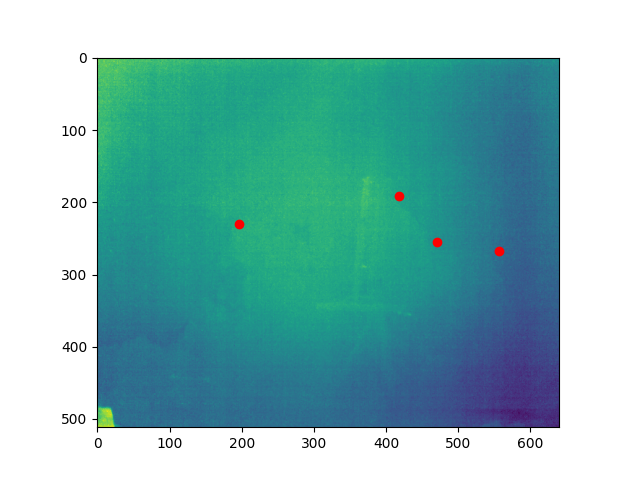

In [11]:
P_est = imP @ la.inv(trans)
extr_im_est = la.inv(imK) @ P_est

pts_in_estCam = (extr_im_est @ pts_world_hat.T).T
pts_in_estCam

reproj_by_imext = (imK @ pts_in_estCam.T).T
reproj_by_imext = np.array([reproj_by_imext[:,0] / reproj_by_imext[:,-1], reproj_by_imext[:,1] / reproj_by_imext[:,-1]]).T
reproj_by_imext

plt.figure()
plt.imshow(imIm)
plt.scatter(reproj_by_imext[:,0],reproj_by_imext[:,1], c="r")
plt.show()

# use native camera

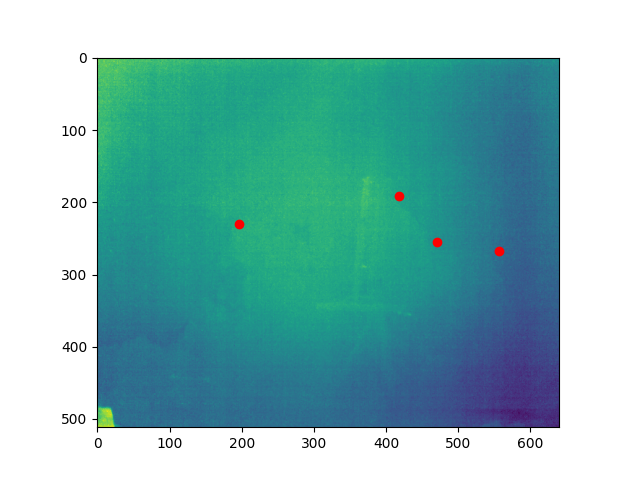

In [12]:
extrinsic_matrix_native = np.matmul(la.inv(imK), imP) 
extrinsic_matrix_native_hat = np.vstack((extrinsic_matrix_native,[0,0,0,1]))
pose_matrix = la.inv(extrinsic_matrix_native_hat)
camera_pose_matrix_native = pose_matrix

box_world_camera_hat = np.hstack((pts_in_estCam,np.ones((pts_in_estCam.shape[0],1))))
box_native_tf = np.matmul(camera_pose_matrix_native, box_world_camera_hat.T).T[:,:3]
box_native_tf_hat = np.hstack((box_native_tf,np.ones((box_native_tf.shape[0],1))))

reproj_by_imP = (imP @ box_native_tf_hat.T).T
reproj_by_imP = np.array([ reproj_by_imP[:,0]/ reproj_by_imP[:,-1],reproj_by_imP[:,1]/ reproj_by_imP[:,-1]]).T

plt.figure()
plt.imshow(imIm)
plt.scatter(reproj_by_imP[:,0],reproj_by_imP[:,1], c="r")
plt.show()

In [13]:
print(f"correct native cps points\n{box_native_tf}")

correct native cps points
[[     -1.40      -6.10       0.45]
 [      0.23      -7.95       0.68]
 [      1.43      -8.42      -0.43]
 [     10.32     -11.45       0.97]]


In [16]:
def pinhole_position(P):
    return (la.null_space(P) / la.null_space(P)[-1])[:3].flatten()

def get_scaling(K,P):
    e = la.inv(K) @ P
    scales = [la.norm(e[:3,0]),la.norm(e[:3,1]),la.norm(e[:3,2])]
    scale = la.norm(scales) / la.norm([1,1,1])
    return scale

p1_native = pinhole_position(exp1.load_imP())
p1_world = pinhole_position(exp1.load_imP() @ exp1.load_transform())

scale = get_scaling(imK, imP)
print(scale)

pos1_native= (extrinsic_matrix_native @ np.append(p1_native,[1]))[:3]
pos1_world = (extr_im_est @ np.append(p1_world,[1]))[:3]

print(pos1_native,pos1_world)

0.39107712441268583
[     -2.58       5.36      -0.47       1.00]


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 5 is different from 4)